# 

- **Questions**: [Here](../data/homework_3/HW.pdf)
- **Answer Set** : NO. 03
- **Full Name** : Fatemeh Karimi Barikarasfi
- **Student Code** : 610301060

The goal of this homework is design the model for text retrieval purpose based on the IDF-TF algorithm.

[Lisa](../data/homework_3/lisa)

## Importing Needed Libraries

In [1]:
import numpy as np
import pandas as pd
import nltk as nltk
import sklearn as sklearn
import scipy.spatial as sp
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## importing data
 these 2 generator are used for generating data.

In [2]:
def document_generator():
    files = [ "LISA0.001", "LISA0.501", "LISA1.001", "LISA1.501", 
              "LISA2.001", "LISA2.501", "LISA3.001", "LISA3.501", 
              "LISA4.001", "LISA4.501", "LISA5.001", "LISA5.501", "LISA5.627", "LISA5.850"]

    for name in files:
        with open(name, "r") as file:
            document = ""
            for line in file:
                if line.rstrip() == "********************************************":
                    yield document.split("\n")[:3]
                    document = ""
                    continue
                
                if line.startswith("Document "):
                    document += line.split(" ")[-1]
                else:
                    document += "\n" if line.replace(" ", "") == "\n" else line.replace("\n", " ")

In [3]:
def query_generator():
    result = []
    
    with open("LISA.QUE", "r") as file:
        query = ""
        for line in file:
            if line.rstrip().endswith("#"):
                query += line.replace(" #", "").rstrip()
                result.append(query)
                query = ""
                continue

            if not line.rstrip().isnumeric() and line != "\n":
                query += line.replace("\n", " ")
    
    index = 0
    with open("LISA.REL", "r") as file:
        ref = ""
        for line in file:
            if line.rstrip().endswith("-1"):
                ref += line.replace(" -1", "").rstrip()
                result[index] = (result[index], ref.split(" "))
                index += 1
                ref = ""
                continue

            if line.replace(" ", "").replace("-1", "").rstrip().isnumeric():
                ref += line.replace("-1", "").replace("\n", " ")

    return result

## Preprocessing

In [5]:
collection = list(document_generator())
a = 0
i = 0
for item in collection:
    if len(item) != 3:
        a = a + 1
        print(i)
        print(item)
        collection.remove(item)
    i = i + 1

1996
['POTENTIAL APPLICATIONS OF SUCH DISCS IN MODERN INFORMATION MANAGEMENT SYSTEMS, E.G. FOR PROVIDING REAL-TIME ACCESS TO SOURCE DOCUMENT ARCHIVES. CONCLUDES THAT, PROVIDED PROBLEMS WITH RESOLUTION AND ARCHIVAL QUALITY ARE RESOLVED, OPTICAL DISC TECHNOLOGY WILL HAVE A MAJOR IMPACT ON THE INFORMATION STORAGE AND RETRIEVAL FIELD AND THAT DIGITAL OPTICAL RECORDING SYSTEMS USING THIN FILM DISCS WILL BE VIABLE BY 1985-86 AND WILL BE PRESENTING MAJOR COMPETITION TO COMPUTER-OUTPUT-MICROFORMS AND MAGNETIC TAPE STORAGE SYSTEMS BY 1990. ']


In [6]:
documents = [item[2] for item in collection]
queries   = [item[1] for item in collection]
document_number = [item[0] for item in collection]

Do removing unwanted digits, unwanted punchuations, lowering all characters, word tokenization, removing stopwords, and stemming as preprocessing:

In [7]:
unwanted_digit=['0','1','2','3','4','5','6','7','8','9']
unwanted_punc=['.',',','"','=','@','&','%',',',':','\\','$','^','<','>','{','}',';','\n','\t','(',')','[',']','/','*','+','#','-','_','|']

# removing unwanted digits
for digit in unwanted_digit:
    documents = [sent.replace(digit, "") for sent in documents]
    queries   = [sent.replace(digit, "") for sent in queries]

# removing unwanted punchuations
for punc in unwanted_punc:
    documents = [sent.replace(punc, "") for sent in documents]
    queries   = [sent.replace(punc, "") for sent in queries]

# loweing all characters
documents = [sent.lower() for sent in documents]
queries   = [sent.lower() for sent in queries]

# word tokenization
documents = [nltk.word_tokenize(sent) for sent in documents]
queries   = [nltk.word_tokenize(sent) for sent in queries]

# removing stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
for i in range(len(documents)):
    documents[i] = [w for w in documents[i] if w not in stop_words]
for i in range(len(queries)):
    queries[i] = [w for w in queries[i] if w not in stop_words]

# stemming
from nltk.stem import PorterStemmer
stemmer=PorterStemmer()
for i in range(len(documents)):
    documents[i] = [stemmer.stem(w) for w in documents[i]]
for i in range(len(queries)):
    queries[i] = [stemmer.stem(w) for w in queries[i]]

Unique words of queries and documents:

In [13]:
queries_words   = [word for sent in queries for word in sent]
documents_words = [word for sent in documents for word in sent]

queries_words = dict(nltk.FreqDist(queries_words)).keys()
documents_words = dict(nltk.FreqDist(documents_words)).keys()

## TF-IDF

In [18]:
documents = list(
    map(lambda x: x[2],
        filter(lambda x: len(x) == 3,
           document_generator()
        )
    )
)
queries = list(
    map(lambda x: x[0],
        filter(lambda x: len(x) == 2,
           query_generator()
        )
    )
)

In [19]:
unwanted_digit = ['0','1','2','3','4','5','6','7','8','9']
unwanted_punc = ['.',',','"','=','@','&','%',',',':','\\','$','^','<','>','{','}',';','\n','\t','(',')','[',']','/','*','+','#','-','_','|']
stop_words = nltk.corpus.stopwords.words("english")
stemmer = nltk.stem.PorterStemmer()

def tokenizer(sentence):
    for digit in unwanted_digit:
        sentence = sentence.replace(digit, "")
    
    for punc in unwanted_punc:
        sentence = sentence.replace(punc, "")
    
    return [
        stemmer.stem(word)
        for word in nltk.word_tokenize(sentence.lower())
        if word not in stop_words
    ]

In [20]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(tokenizer=tokenizer).fit(documents)

documents_tfidf = vectorizer.transform(documents)
queries_tfidf = vectorizer.transform(queries)

For the different number of documents which are retrieved, we evaluate the TF-IDF model with the fuction that write below:

In [21]:
def find_similars(documents_vectors, queries_vectors, n):
    sims = 1 - sp.distance.cdist(documents_vectors, queries_vectors, 'cosine')
    
    reference_keys = list([x[1] for x in query_generator() if len(x) == 2])
    
    document_nums = list([x[0] for x in document_generator() if len(x) == 3])
    predict_keys = list([
        [document_nums[key] for key in row]
        for row in np.argsort(sims, axis=0)[::-1][:n].T
    ])
    
    references = [
        1 if str(document_idx) in reference_keys[query_idx] else 0
        for document_idx in range(6004)
        for query_idx in range(33)
    ]

    predicts = [
        1 if str(document_idx) in predict_keys[query_idx] else 0
        for document_idx in range(6004)
        for query_idx in range(33)
    ]
    
    return (references, predicts)

### Number of documents that are retrieved = 5

In [22]:
(trues, preds) = find_similars(documents_tfidf.toarray(), queries_tfidf.toarray(), 5)

print(f"precision: {sklearn.metrics.precision_score(trues, preds)}")
print(f"recall: {sklearn.metrics.recall_score(trues, preds)}")
print(f"f1: {sklearn.metrics.f1_score(trues, preds)}")

precision: 0.2606060606060606
recall: 0.12146892655367232
f1: 0.16570327552986513


### Number of documents that are retrieved = 10

In [23]:
(trues, preds) = find_similars(documents_tfidf.toarray(), queries_tfidf.toarray(), 10)

print(f"precision: {sklearn.metrics.precision_score(trues, preds)}")
print(f"recall: {sklearn.metrics.recall_score(trues, preds)}")
print(f"f1: {sklearn.metrics.f1_score(trues, preds)}")

precision: 0.23030303030303031
recall: 0.21468926553672316
f1: 0.22222222222222224


### Number of documents that are retrieved = 20

In [24]:
(trues, preds) = find_similars(documents_tfidf.toarray(), queries_tfidf.toarray(), 20)

print(f"precision: {sklearn.metrics.precision_score(trues, preds)}")
print(f"recall: {sklearn.metrics.recall_score(trues, preds)}")
print(f"f1: {sklearn.metrics.f1_score(trues, preds)}")

precision: 0.17272727272727273
recall: 0.3220338983050847
f1: 0.22485207100591714


### Number of documents that are retrieved = 40

In [25]:
(trues, preds) = find_similars(documents_tfidf.toarray(), queries_tfidf.toarray(), 40)

print(f"precision: {sklearn.metrics.precision_score(trues, preds)}")
print(f"recall: {sklearn.metrics.recall_score(trues, preds)}")
print(f"f1: {sklearn.metrics.f1_score(trues, preds)}")

precision: 0.11287878787878788
recall: 0.4209039548022599
f1: 0.1780167264038232


## LSI

In this section, we use LSI algorithm for dimentionality reduction. Then plot the vector corresponding to the first 10 queries along with the closest one.

In [26]:
import sklearn.decomposition
svd = sklearn.decomposition.TruncatedSVD(n_components=2).fit(documents_tfidf)

documents_svd = svd.transform(documents_tfidf)
queries_svd = svd.transform(queries_tfidf)

In [27]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

def draw_points(documents_vectors, queries_vectors, n):
    distances = 1 - sp.distance.cdist(documents_vectors, queries_vectors, 'cosine')
    similars = np.argsort(distances, axis=0)[::-1][:n].T
    
    colors = plt.cm.get_cmap('hsv', 33)
    
    for i in range(len(queries_vectors)):
        plt.scatter(x=[queries_vectors[i][0]], y=[queries_vectors[i][1]], c=[colors(i)], marker='o')
        
        for similar in similars[i]:
            plt.scatter(x=[documents_vectors[similar][0]], y=[documents_vectors[similar][1]], c=[colors(i)], marker='+')
        
    plt.show()

### Number of documents that are retrieved = 5

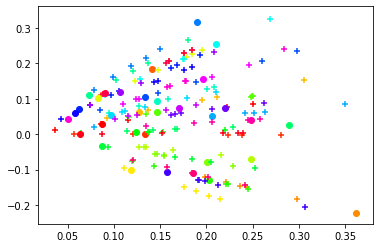

In [28]:
draw_points(documents_svd, queries_svd, 5)

### Number of documents that are retrieved = 10

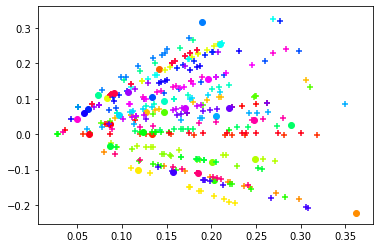

In [29]:
draw_points(documents_svd, queries_svd, 10)

### Number of documents that are retrieved = 20

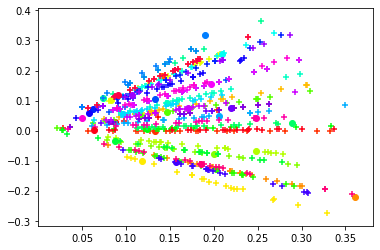

In [30]:
draw_points(documents_svd, queries_svd, 20)

### Number of documents that are retrieved = 40

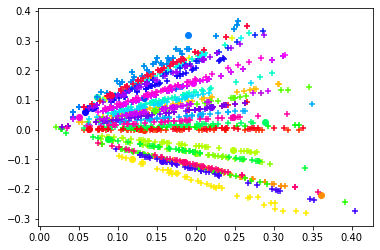

In [31]:
draw_points(documents_svd, queries_svd, 40)